In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
import ipywidgets as widgets

In [2]:
f = uproot.open("/home/users/hdhoang2001/cmssw/src/RecoTracker/LSTCore/standalone/debug.root:tree")

In [3]:
tree = f.arrays(["t3_residual", "t3_isFake", "t3_isPerfect", "t3_region", "t3_rzChiSquared"], library="np")

In [4]:
res = np.concatenate(tree["t3_residual"])
isfake = np.concatenate(tree["t3_isFake"])
isperfect = np.concatenate(tree["t3_isPerfect"])
region = np.concatenate(tree["t3_region"])
rzchi2 = np.concatenate(tree["t3_rzChiSquared"])

In [5]:
res_fake = res[isfake==1]
res_75_99 = res[((1-isfake) & (1-isperfect))==1]
res_100 = res[isperfect==1]

In [29]:
def plot_hist(fake, real_75_99, real_100, xlabel, cut=0, save_file=None):
    fig = plt.figure(figsize=(12, 6))
    histogram = fig.add_subplot(111)
    if cut != 0:
        histogram.hist(fake[fake<cut], bins=100, histtype="step", label="Fake")
        histogram.hist(real_75_99[real_75_99 < cut], bins=100, histtype="step", label="75-99%")
        histogram.hist(real_100[real_100 < cut], bins=100, histtype="step", label="100%")
    else:
        histogram.hist(fake, bins=100, histtype="step", label="Fake")
        histogram.hist(real_75_99, bins=100, histtype="step", label="75-99%")
        histogram.hist(real_100, bins=100, histtype="step", label="100%")
    histogram.legend()
    histogram.set_xlabel(xlabel)
    histogram.set_ylabel("yield")
    if save_file:
        fig.savefig(save_file)


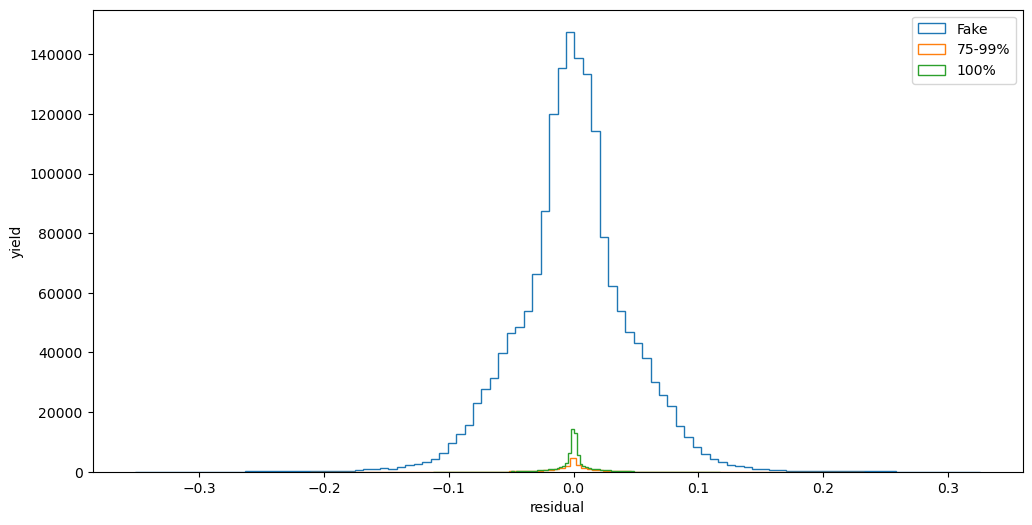

In [30]:
plot_hist(res_fake, res_75_99, res_100, xlabel="residual")

In [31]:
rzchi2_fake = rzchi2[isfake==1]
rzchi2_75_99 = rzchi2[((1-isfake) & (1-isperfect))==1]
rzchi2_100 = rzchi2[isperfect==1]

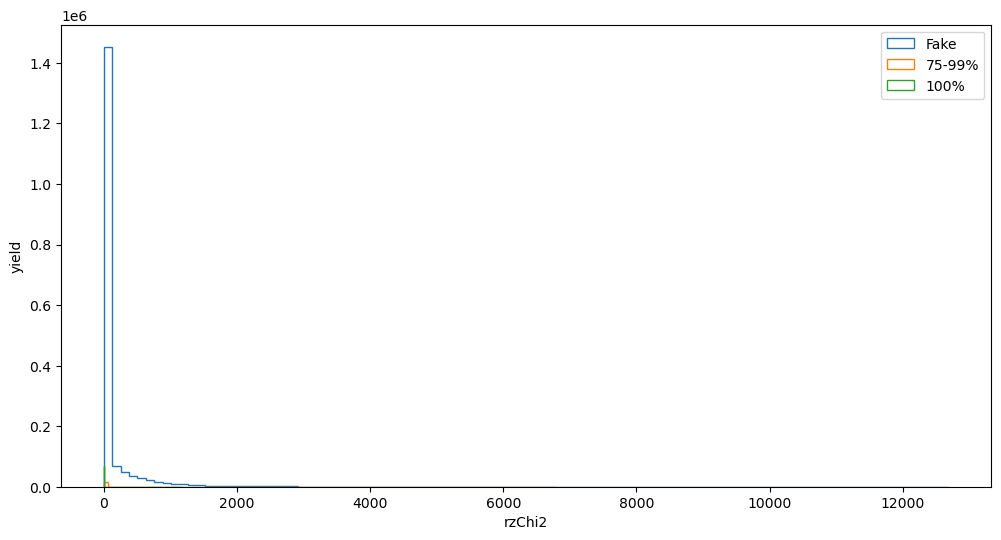

In [32]:
plot_hist(rzchi2_fake, rzchi2_75_99, rzchi2_100, xlabel="rzChi2")

In [10]:
res_by_region = [res[region==i] for i in range(25)]
isfake_by_region = [isfake[region==i] for i in range(25)]
isperfect_by_region = [isperfect[region==i] for i in range(25)]

In [11]:
res_fake_by_region = [res_by_region[i][isfake_by_region[i]==1] for i in range(25)]
res_75_99_by_region = [res_by_region[i][((1-isfake_by_region[i]) & (1-isperfect_by_region[i]))==1] for i in range(25)]
res_100_by_region = [res_by_region[i][isperfect_by_region[i]==1] for i in range(25)]

In [13]:
for i in range(25):
    plot_hist(res_fake_by_region[i], res_75_99_by_region[i], res_100_by_region[i], save_file=f"t3_res_by_region/region_{i}.png")
    plt.close()

In [15]:
rzchi2_by_region = [rzchi2[region==i] for i in range(25)]


In [16]:
rzchi2_fake_by_region = [rzchi2_by_region[i][isfake_by_region[i]==1] for i in range(25)]
rzchi2_75_99_by_region = [rzchi2_by_region[i][((1-isfake_by_region[i]) & (1-isperfect_by_region[i]))==1] for i in range(25)]
rzchi2_100_by_region = [rzchi2_by_region[i][isperfect_by_region[i]==1] for i in range(25)]

In [17]:
for i in range(25):
    plot_hist(rzchi2_fake_by_region[i], rzchi2_75_99_by_region[i], rzchi2_100_by_region[i], save_file=f"t3_rzchi2_by_region/region_{i}.png")
    plt.close()

In [21]:
reg = 1
widgets.interact(plot_hist, 
                 fake=widgets.fixed(rzchi2_fake_by_region[reg]), 
                 real_75_99=widgets.fixed(rzchi2_75_99_by_region[reg]), 
                 real_100=widgets.fixed(rzchi2_100_by_region[reg]),
                 xlabel=widgets.fixed("rzChi2"),
                 cut=widgets.FloatText(value=0, description="cut"),
                 save_file=widgets.fixed(None))

interactive(children=(FloatText(value=0.0, description='cut'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_hist(fake, real_75_99, real_100, cut=0, save_file=None)>